In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load dataset

In [16]:
df = pd.read_csv('nba_elo_latest.csv')

# Data cleaning

In [17]:
columns_to_drop = [
    'carm-elo1_pre', 'carm-elo2_pre', 'carm-elo_prob1', 'carm-elo_prob2', 
    'carm-elo1_post', 'carm-elo2_post'
]

df.drop(columns=columns_to_drop, inplace=True)

In [18]:
df['playoff'].fillna(0, inplace=True)

C:\Users\DS\AppData\Local\Temp\ipykernel_12272\3199909726.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['playoff'].fillna(0, inplace=True)


# Feature engineering

In [19]:
df['elo_diff'] = df['elo1_pre'] - df['elo2_pre']
df['rap_diff'] = df['raptor1_pre'] - df['raptor2_pre']
df['home_win'] = df['score1'] > df['score2']


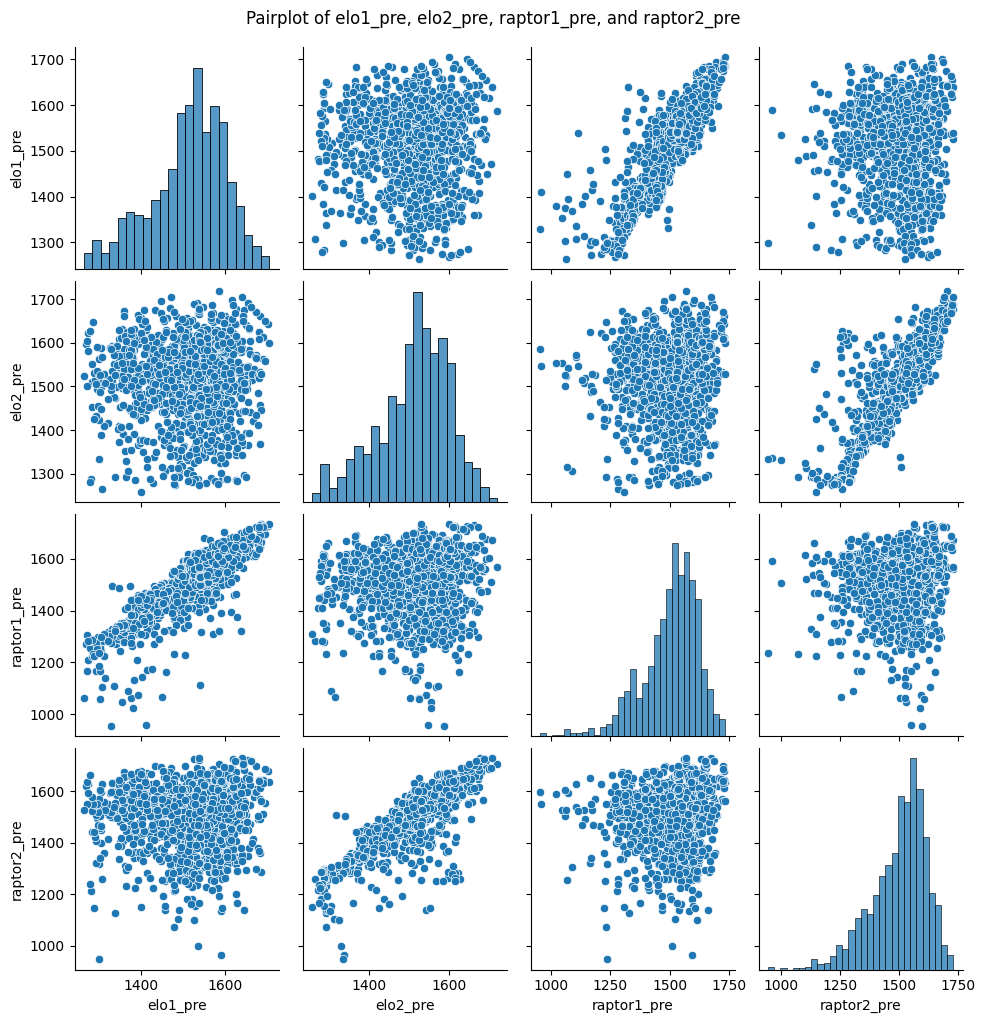

In [20]:
pairplot_columns = ['elo1_pre', 'elo2_pre', 'raptor1_pre', 'raptor2_pre']
sns.pairplot(df[pairplot_columns])
plt.suptitle('Pairplot of elo1_pre, elo2_pre, raptor1_pre, and raptor2_pre', y=1.02)
plt.show()

In [21]:
df['elo1_greater'] = df['elo1_pre'] > df['elo2_pre']
win_percentage = df.groupby('elo1_greater')['home_win'].mean() * 100


plt.figure(figsize=(10, 6))
sns.barplot(x=win_percentage.index, y=win_percentage.values, palette='viridis')
plt.xlabel('Elo1_pre > Elo2_pre')
plt.ylabel('Percentage of Home Wins')
plt.title('Home Win Percentage When Elo1_pre is Greater Than Elo2_pre')
plt.xticks([0, 1], ['False', 'True'])
plt.ylim(0, 100)
for i in range(len(win_percentage)):
    plt.text(i, win_percentage.values[i] + 1, f'{win_percentage.values[i]:.2f}%', ha='center')
plt.show()

C:\Users\DS\AppData\Local\Temp\ipykernel_12272\389427603.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=win_percentage.index, y=win_percentage.values, palette='viridis')


In [22]:
elo_bin_edges = np.linspace(df['elo_diff'].min(), df['elo_diff'].max(), 20)
df['elo_diff_bin'] = pd.cut(df['elo_diff'], bins=elo_bin_edges, include_lowest=True)
rap_bin_edges = np.linspace(df['rap_diff'].min(), df['rap_diff'].max(), 20)
df['rap_diff_bin'] = pd.cut(df['rap_diff'], bins=rap_bin_edges, include_lowest=True)


elo_bin_summary = df.groupby('elo_diff_bin')['elo_prob1'].mean().reset_index()
elo_bin_summary['elo_diff_bin_mid'] = elo_bin_summary['elo_diff_bin'].apply(lambda x: x.mid)
rap_bin_summary = df.groupby('rap_diff_bin')['raptor_prob1'].mean().reset_index()
rap_bin_summary['rap_diff_bin_mid'] = rap_bin_summary['rap_diff_bin'].apply(lambda x: x.mid)


plt.figure(figsize=(14, 8))


sns.lineplot(x='elo_diff_bin_mid', y='elo_prob1', data=elo_bin_summary, marker='o', color='red', linewidth=2, label='Average Elo Probability')


sns.lineplot(x='rap_diff_bin_mid', y='raptor_prob1', data=rap_bin_summary, marker='o', color='green', linewidth=2, label='Average Raptor Probability')


plt.scatter(df['elo_diff'], df['elo_prob1'], alpha=0.3, s=10, color='blue', label='Elo Data Prob1')
plt.scatter(df['rap_diff'], df['raptor_prob1'], alpha=0.3, s=10, color='orange', label='Raptor Data Prob1')


plt.xlabel('Difference (elo_diff or rap_diff)', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title('Probability Based on Elo and Raptor Differences', fontsize=16, pad=20)


plt.yticks(np.linspace(0, 1, 11), ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'], fontsize=12)


plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

C:\Users\DS\AppData\Local\Temp\ipykernel_12272\852514976.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elo_bin_summary = df.groupby('elo_diff_bin')['elo_prob1'].mean().reset_index()


C:\Users\DS\AppData\Local\Temp\ipykernel_12272\852514976.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rap_bin_summary = df.groupby('rap_diff_bin')['raptor_prob1'].mean().reset_index()


C:\Users\DS\AppData\Local\Temp\ipykernel_12272\2976497388.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elo_bin_summary = df.groupby('elo_diff_bin').agg({'elo_prob1': 'mean', 'home_win': 'mean'}).reset_index()
C:\Users\DS\AppData\Local\Temp\ipykernel_12272\2976497388.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rap_bin_summary = df.groupby('rap_diff_bin').agg({'raptor_prob1': 'mean', 'home_win': 'mean'}).reset_index()


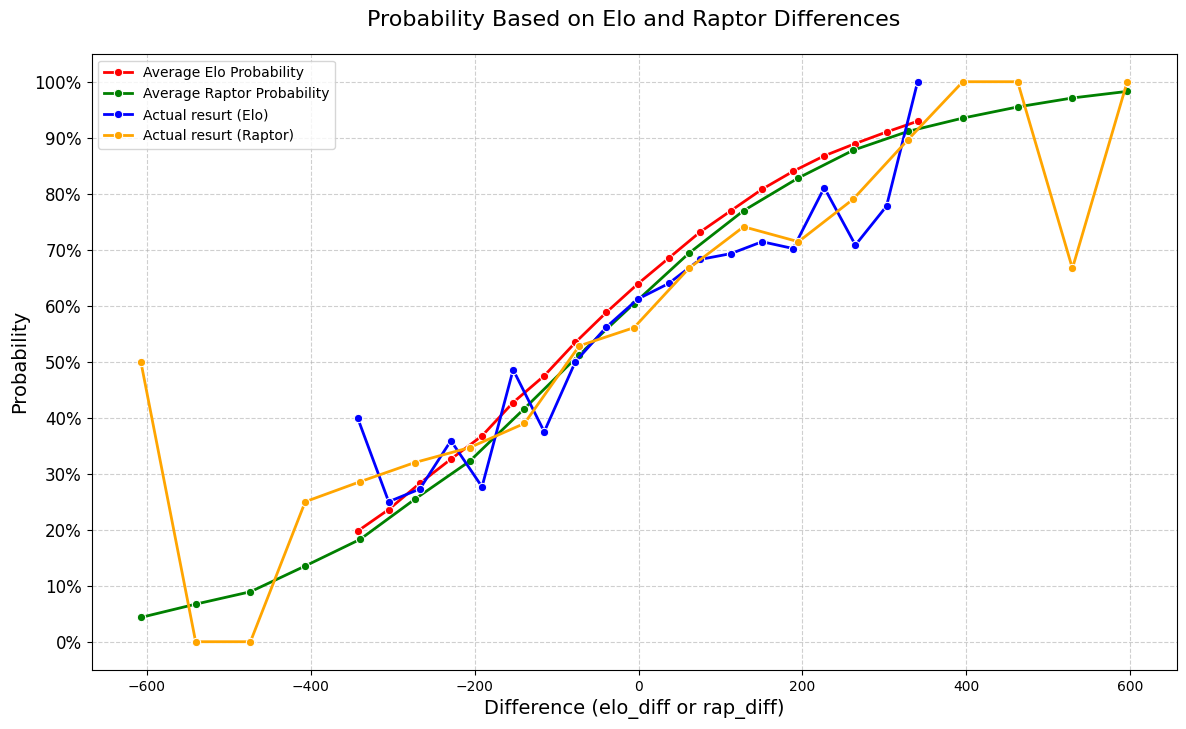

In [23]:
elo_bin_edges = np.linspace(df['elo_diff'].min(), df['elo_diff'].max(), 20)
df['elo_diff_bin'] = pd.cut(df['elo_diff'], bins=elo_bin_edges, include_lowest=True)
rap_bin_edges = np.linspace(df['rap_diff'].min(), df['rap_diff'].max(), 20)
df['rap_diff_bin'] = pd.cut(df['rap_diff'], bins=rap_bin_edges, include_lowest=True)

elo_bin_summary = df.groupby('elo_diff_bin').agg({'elo_prob1': 'mean', 'home_win': 'mean'}).reset_index()
elo_bin_summary['elo_diff_bin_mid'] = elo_bin_summary['elo_diff_bin'].apply(lambda x: x.mid)
rap_bin_summary = df.groupby('rap_diff_bin').agg({'raptor_prob1': 'mean', 'home_win': 'mean'}).reset_index()
rap_bin_summary['rap_diff_bin_mid'] = rap_bin_summary['rap_diff_bin'].apply(lambda x: x.mid)

plt.figure(figsize=(14, 8))
sns.lineplot(x='elo_diff_bin_mid', y='elo_prob1', data=elo_bin_summary, marker='o', color='red', linewidth=2, label='Average Elo Probability')
sns.lineplot(x='rap_diff_bin_mid', y='raptor_prob1', data=rap_bin_summary, marker='o', color='green', linewidth=2, label='Average Raptor Probability')
sns.lineplot(x='elo_diff_bin_mid', y='home_win', data=elo_bin_summary, marker='o', color='blue', linewidth=2, label='Actual resurt (Elo)')
sns.lineplot(x='rap_diff_bin_mid', y='home_win', data=rap_bin_summary, marker='o', color='orange', linewidth=2, label='Actual resurt (Raptor)')


plt.xlabel('Difference (elo_diff or rap_diff)', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title('Probability Based on Elo and Raptor Differences', fontsize=16, pad=20)


plt.yticks(np.linspace(0, 1, 11), ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'], fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# Select features and target

In [24]:
features = ['elo_prob1', 'raptor_prob1', 'elo_diff', 'rap_diff']
target = 'home_win'

X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Data normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model 1: Random Forest

In [26]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Model 2: Logistic Regression

In [27]:
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [28]:
# Baseline Model
baseline_pred = [y_train.mode()[0]] * len(y_test)

In [29]:
# Random Forest Hyperparameter Tuning
rf_params = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
rf_grid = GridSearchCV(rf_model, rf_params, cv=5)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

# Logistic Regression Hyperparameter Tuning
lr_params = {'C': [0.1, 1, 10]}
lr_grid = GridSearchCV(lr_model, lr_params, cv=5)
lr_grid.fit(X_train, y_train)
best_lr = lr_grid.best_estimator_

In [30]:
# Predictions
rf_preds = best_rf.predict(X_test)
lr_preds = best_lr.predict(X_test)

# Evaluation
rf_accuracy = accuracy_score(y_test, rf_preds)
lr_accuracy = accuracy_score(y_test, lr_preds)
baseline_accuracy = accuracy_score(y_test, baseline_pred)

print("Random Forest Accuracy:", rf_accuracy)
print("Logistic Regression Accuracy:", lr_accuracy)
print("Baseline Accuracy:", baseline_accuracy)

Random Forest Accuracy: 0.6515151515151515
Logistic Regression Accuracy: 0.6893939393939394
Baseline Accuracy: 0.625


In [31]:
# Confusion Matrix
rf_cm = confusion_matrix(y_test, rf_preds)
lr_cm = confusion_matrix(y_test, lr_preds)

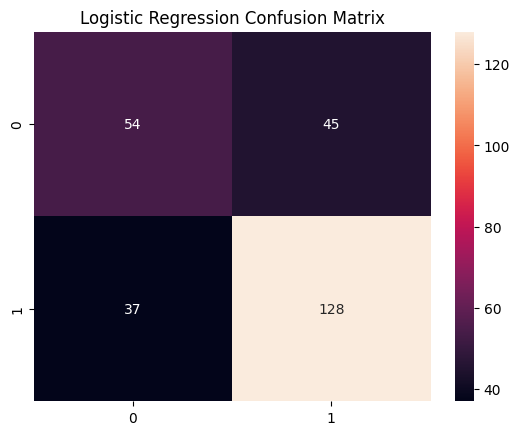

In [32]:
sns.heatmap(rf_cm, annot=True, fmt='d')
plt.title('Random Forest Confusion Matrix')
plt.savefig('random_forest_cm.png')
plt.show()

sns.heatmap(lr_cm, annot=True, fmt='d')
plt.title('Logistic Regression Confusion Matrix')
plt.savefig('logistic_regression_cm.png')
plt.show()

In [33]:
# Classification Report
print("Random Forest Classification Report:\n", classification_report(y_test, rf_preds))
print("Logistic Regression Classification Report:\n", classification_report(y_test, lr_preds))

Random Forest Classification Report:
               precision    recall  f1-score   support

       False       0.54      0.54      0.54        99
        True       0.72      0.72      0.72       165

    accuracy                           0.65       264
   macro avg       0.63      0.63      0.63       264
weighted avg       0.65      0.65      0.65       264

Logistic Regression Classification Report:
               precision    recall  f1-score   support

       False       0.59      0.55      0.57        99
        True       0.74      0.78      0.76       165

    accuracy                           0.69       264
   macro avg       0.67      0.66      0.66       264
weighted avg       0.68      0.69      0.69       264

